In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from tcn import TCN


In [2]:
datasets = joblib.load("all_pollutant_datasets.pkl")

POLLUTANTS = ["PM25", "PM10", "NO2", "SO2", "O3", "CO", "NOX"]


Temporal Train / Val / Test Split

In [3]:
from pandas.tseries.offsets import DateOffset

def temporal_split(df):
    last_date = df["datetime"].max()
    test_start = last_date - DateOffset(months=6)
    val_start  = test_start - DateOffset(months=6)

    train = df[df["datetime"] < val_start]
    val   = df[(df["datetime"] >= val_start) & (df["datetime"] < test_start)]
    test  = df[df["datetime"] >= test_start]

    return train, val, test


In [4]:
BASE_FEATURES = [
    "lat", "lon",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month", "is_weekend",
    "u", "v",
    "AT", "RH", "BP", "SolarRad", "Rain"
]

def get_feature_columns(df, target):
    lag_features = [
        c for c in df.columns
        if c.startswith(target+"_") or
           any(c.startswith(x+"_") for x in ["WS", "AT", "RH", "BP"])
    ]
    return BASE_FEATURES + lag_features


In [5]:
def scale_features(train, val, test, feature_cols):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_val   = scaler.transform(val[feature_cols])
    X_test  = scaler.transform(test[feature_cols])
    return X_train, X_val, X_test, scaler


Create Sequences (TCN Needs This)

In [6]:
def create_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)


Build TCN Model

In [7]:
def build_tcn(input_shape):
    model = Sequential([
        TCN(
            nb_filters=64,
            kernel_size=3,
            dilations=[1, 2, 4, 8, 16],
            dropout_rate=0.2,
            return_sequences=False,
            input_shape=input_shape
        ),
        Dense(1)
    ])

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    return model


Evaluation Function

In [8]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


In [10]:
results = {}
predictions = {}

for target in POLLUTANTS:
    print(f"\n===== Training TCN for {target} =====")

    df = datasets[target]
    features = get_feature_columns(df, target)

    train, val, test = temporal_split(df)

    X_train, X_val, X_test, scaler = scale_features(train, val, test, features)
    y_train, y_val, y_test = train[target], val[target], test[target]

    X_train_seq, y_train_seq = create_sequences(X_train, y_train)
    X_val_seq, y_val_seq     = create_sequences(X_val, y_val)
    X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

    model = build_tcn((X_train_seq.shape[1], X_train_seq.shape[2]))

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=40,
        batch_size=128,
        callbacks=[EarlyStopping(patience=6, restore_best_weights=True)],
        verbose=1
    )

    preds = model.predict(X_test_seq).ravel()
    rmse, mae, r2 = evaluate(y_test_seq, preds)

    print(f"{target} → RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

    results[target] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    predictions[target] = (y_test_seq, preds)

    


===== Training TCN for PM25 =====


c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - loss: 158.8191 - mae: 8.8075 - val_loss: 68.5920 - val_mae: 5.7832
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 102.4407 - mae: 7.0196 - val_loss: 67.1265 - val_mae: 5.5818
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 86.4724 - mae: 6.3994 - val_loss: 62.7834 - val_mae: 5.3250
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 80.1275 - mae: 6.2098 - val_loss: 59.1395 - val_mae: 5.1986
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 74.7185 - mae: 5.9392 - val_loss: 58.3752 - val_mae: 5.1444
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 71.7595 - mae: 5.8296 - val_loss: 53.5197 - val_mae: 4.9332
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 68.8220 - mae: 5.7289 - val_loss: 58.4775 - val_mae: 5.1583
Epoch 8/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 66.2366 - mae: 5.5970 - val_loss: 52.7236 - val_mae: 4.9137
Epoch 9/40
114/114 ━━━━━━━━━

c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 493.6768 - mae: 15.7838 - val_loss: 204.6705 - val_mae: 10.2490
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 258.7801 - mae: 11.6094 - val_loss: 199.8102 - val_mae: 10.0423
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 219.9282 - mae: 10.6437 - val_loss: 185.7680 - val_mae: 9.7418
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 198.8442 - mae: 10.0389 - val_loss: 165.7317 - val_mae: 9.1318
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 184.9190 - mae: 9.7112 - val_loss: 184.9101 - val_mae: 9.7945
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 179.0907 - mae: 9.5096 - val_loss: 171.4957 - val_mae: 9.3969
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 169.2561 - mae: 9.2565 - val_loss: 154.1493 - val_mae: 8.7749
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 160.8601 - mae: 9.0223 - val_loss: 156.3732 - val_mae: 8.8884
Epoch 9/4

c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - loss: 40.6263 - mae: 4.6235 - val_loss: 15.0405 - val_mae: 2.9887
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 23.8471 - mae: 3.5276 - val_loss: 13.7845 - val_mae: 2.8679
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 20.3795 - mae: 3.2150 - val_loss: 9.8117 - val_mae: 2.3671
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 18.4678 - mae: 3.0429 - val_loss: 9.7271 - val_mae: 2.3708
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 17.3355 - mae: 2.9394 - val_loss: 9.9105 - val_mae: 2.3984
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 16.5883 - mae: 2.8509 - val_loss: 8.4507 - val_mae: 2.1989
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 15.8889 - mae: 2.7835 - val_loss: 8.3997 - val_mae: 2.1980
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 15.4524 - mae: 2.7315 - val_loss: 8.5076 - val_mae: 2.2084
Epoch 9/40
117/117 ━━━━━━━━━━━━━━━━━━

c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 20.1059 - mae: 2.5283 - val_loss: 2.1400 - val_mae: 1.1600
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 10.6311 - mae: 1.6810 - val_loss: 2.2207 - val_mae: 1.1850
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 9.9447 - mae: 1.5046 - val_loss: 1.5793 - val_mae: 0.9909
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 9.5459 - mae: 1.4356 - val_loss: 1.7175 - val_mae: 1.0269
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 8.9217 - mae: 1.3659 - val_loss: 1.6454 - val_mae: 1.0162
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 8.9182 - mae: 1.3192 - val_loss: 1.5697 - val_mae: 0.9839
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 8.6477 - mae: 1.3003 - val_loss: 1.0576 - val_mae: 0.8078
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 8.2735 - mae: 1.2575 - val_loss: 1.6483 - val_mae: 1.0170
Epoch 9/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 68

c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 67.5721 - mae: 5.9263 - val_loss: 22.1412 - val_mae: 3.3427
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 41.5357 - mae: 4.6018 - val_loss: 17.8155 - val_mae: 3.0216
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 34.9155 - mae: 4.1779 - val_loss: 16.8922 - val_mae: 2.9521
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 31.1306 - mae: 3.9295 - val_loss: 15.7646 - val_mae: 2.8177
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 28.2382 - mae: 3.7551 - val_loss: 14.8110 - val_mae: 2.7501
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 27.1485 - mae: 3.6536 - val_loss: 15.8738 - val_mae: 2.8729
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 26.2654 - mae: 3.5774 - val_loss: 14.9183 - val_mae: 2.7838
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 24.5157 - mae: 3.4526 - val_loss: 13.6750 - val_mae: 2.6364
Epoch 9/40
117/117 ━━━━━━

c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 101952.1953 - mae: 229.7582 - val_loss: 96174.9219 - val_mae: 197.0600
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 59874.3438 - mae: 172.5491 - val_loss: 95253.6953 - val_mae: 196.9487
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 52677.3984 - mae: 162.0399 - val_loss: 73179.5312 - val_mae: 173.9002
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 45789.2227 - mae: 151.5930 - val_loss: 81297.4922 - val_mae: 196.7294
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 40719.7773 - mae: 143.2006 - val_loss: 74123.4609 - val_mae: 195.3386
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 36602.2148 - mae: 135.5350 - val_loss: 63773.9258 - val_mae: 174.1073
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 33819.8867 - mae: 130.1737 - val_loss: 54023.4570 - val_mae: 155.8049
Epoch 8/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 32629.4258 - mae

c:\Users\nimas\Desktop\Research\My research\my_venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 216.7441 - mae: 10.1764 - val_loss: 108.9735 - val_mae: 6.7421
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 143.5149 - mae: 8.0255 - val_loss: 85.6396 - val_mae: 5.9898
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 128.8307 - mae: 7.4776 - val_loss: 86.7843 - val_mae: 5.9235
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 119.1397 - mae: 7.1348 - val_loss: 75.6339 - val_mae: 5.4961
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 112.4017 - mae: 6.8700 - val_loss: 72.9156 - val_mae: 5.4111
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 106.3876 - mae: 6.6878 - val_loss: 86.9347 - val_mae: 6.0726
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 103.8053 - mae: 6.5950 - val_loss: 71.0272 - val_mae: 5.2862
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 99.7660 - mae: 6.4517 - val_loss: 75.9369 - val_mae: 5.4598
Epoch 9/40
117/117

In [11]:
print("\n===== TCN Performance Summary =====")
for pol, metrics in results.items():
    print(
        f"{pol}: "
        f"RMSE = {metrics['RMSE']:.3f}, "
        f"MAE = {metrics['MAE']:.3f}, "
        f"R² = {metrics['R2']:.3f}"
    )



===== TCN Performance Summary =====
PM25: RMSE = 5.986, MAE = 4.433, R² = 0.778
PM10: RMSE = 11.151, MAE = 8.356, R² = 0.731
NO2: RMSE = 3.906, MAE = 2.793, R² = 0.765
SO2: RMSE = 0.736, MAE = 0.593, R² = 0.187
O3: RMSE = 5.116, MAE = 3.687, R² = 0.758
CO: RMSE = 185.777, MAE = 131.086, R² = 0.627
NOX: RMSE = 9.169, MAE = 6.283, R² = 0.681


In [15]:
# Save model (SAFE for TCN)
for target in POLLUTANTS:
    model.save(f"models/TCN_{target}.keras")


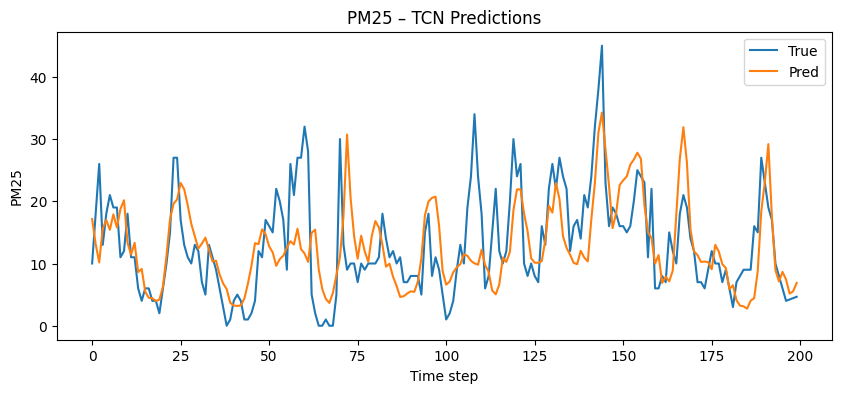

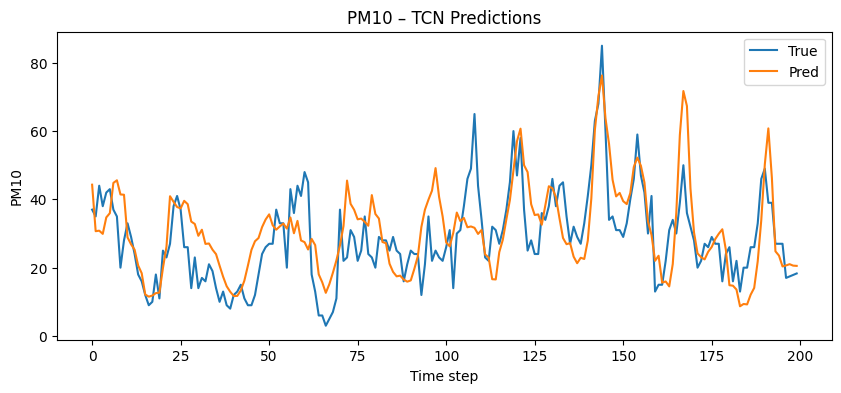

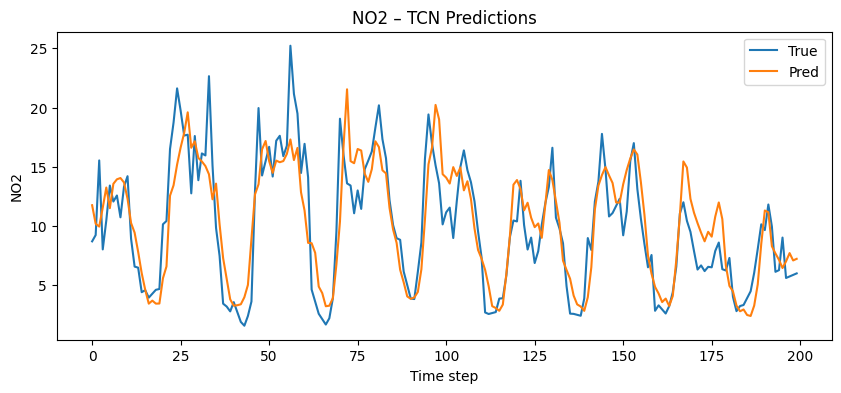

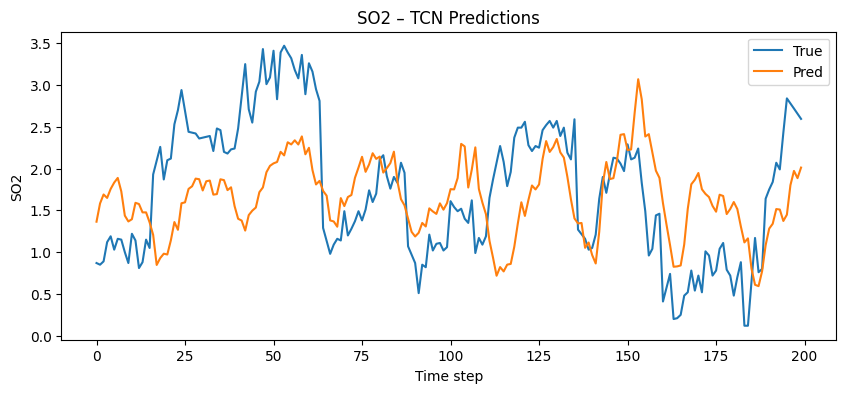

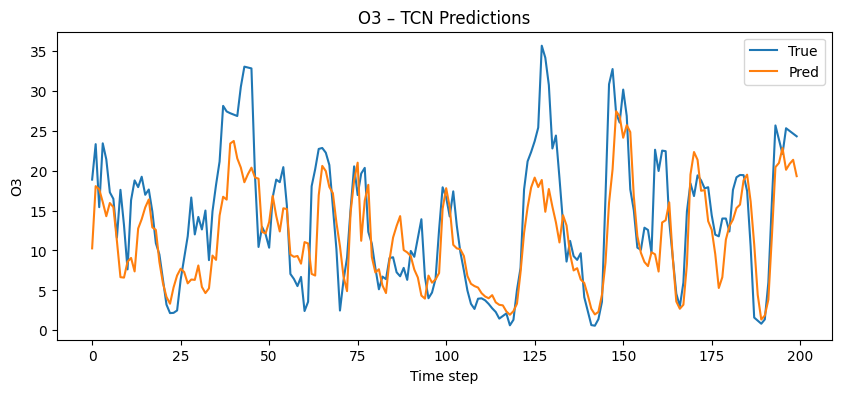

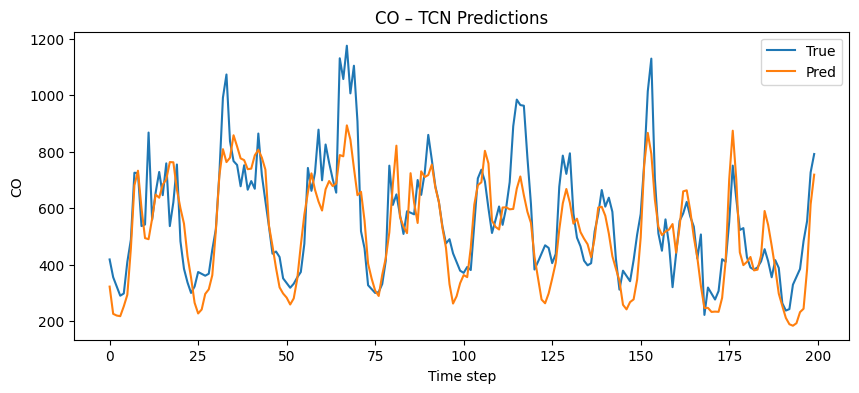

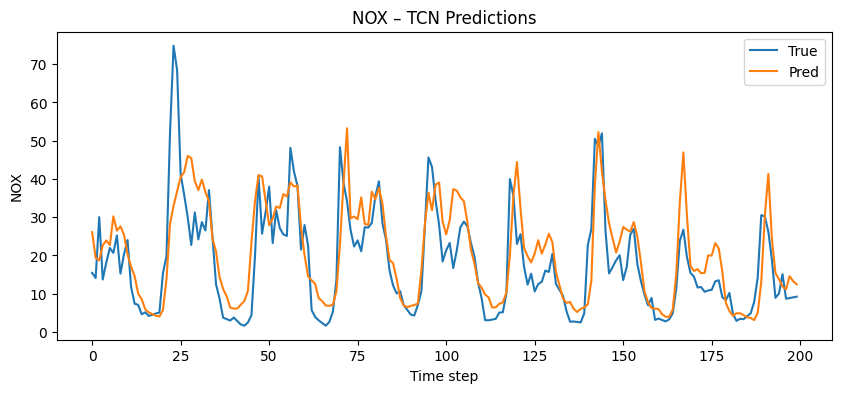

In [16]:
for pol in POLLUTANTS:
    y_true, y_pred = predictions[pol]
    plt.figure(figsize=(10,4))
    plt.plot(y_true[:200], label="True")
    plt.plot(y_pred[:200], label="Pred")
    plt.title(f"{pol} – TCN Predictions")
    plt.xlabel("Time step")
    plt.ylabel(pol)
    plt.legend()
    plt.show()
